# Combining Sketch & Tone for Pencil Drawing Production
## Python Implementation
### Based on the paper "Combining Sketch and Tone for Pencil Drawing Production" by Cewu Lu, Li Xu, Jiaya Jia
#### International Symposium on Non-Photorealistic Animation and Rendering (NPAR 2012), June 2012
Project site can be found here:
http://www.cse.cuhk.edu.hk/leojia/projects/pencilsketch/pencil_drawing.htm

Paper PDF - http://www.cse.cuhk.edu.hk/leojia/projects/pencilsketch/npar12_pencil.pdf

Draws inspiration from the Matlab implementation by "candtcat1992" - https://github.com/candycat1992/PencilDrawing

In this notebook, we will explain and implement the algorithm described in the paper. This is what we are trying to achieve:
<img src="./images/ExampleResult.jpg" />

We can divide the workflow into 2 main steps:
1. Pencil stroke generation (captures the general strucure of the scene)
2. Pencil tone drawing (captures shapes shadows and shading)

Combining the results from these steps should yield the desired result. The workflow can be depicted as follows:
<img src="./images/Workflow.jpg" />

* Both figures were taken from the original paper

### Line Drawing with Strokes
The initial step is to smooth the image using a smoothing filter, Median and Gaussian should do the trick.

In this method, we approximate sketchy lines by determining the direction, length and width in  a pixel classification. The classification is done by computing the gradients on the grayscale version of the input image (or the Y - brightness channel in YUV space) to yield the magnitude (we can use 2 methods: Sobel and the regular way): $$ G = \sqrt{(\partial_xI)^2 + (\partial_yI)^2} $$
Then, we choose a number of directions, 8 in our case, which serve as reference directions, from them we create 8 line segements the act as convolurional kernels. The kernel's size is usually set to be 1/30 of the input image's height/width. We denote thos line segements by $ L_i, i \in [1..8] $

Using these kernels, we create response map for each direction using the convolution operation: $$ G_i = L_i \otimes G $$
We now can perform the classification - selecting the maximum value among the responses in all directions:
$$ C_i(p) =
  \begin{cases}
    G(p)       & \quad \text{if } argmax_i(G_i(p))=i \\
    0  & \quad \text{else}
  \end{cases}
$$
p indexes pixels (we work pixel-by-pixel), $C_i$ is the magnitude map for direction $i$. It suffices that: $$\sum_{i=1}^{8}C_i = G $$
We reach the last part of the line drawing, which is Line Shaping - given the map set {$C_i$}, we generate lines at each pixel using convolution as follows: $$ S' = \sum_{i=1}^{8} L_i \otimes C_i $$ This links edge pixels that are not even connected in the original gradient map.

The final pencil stroke map S: Invert pixel values of S' and map to [0,1].

The process looks like:
<img src="./images/LineShaping.jpg" />

In [1]:
# imports
import numpy as np
import cv2
from skimage import io, color, filters, transform, exposure
from scipy import signal, sparse
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Generate Stroke Map
def gen_stroke_map(img, kernel_size, stroke_width=0, num_of_directions=8, smooth_kernel="gauss", gradient_method=0):
    height = img.shape[0] # number of rows, height of the image
    width = img.shape[1] # number of columns, width of the image
    # Let's start with smoothing
    if (smooth_kernel == "gauss"):
        smooth_im = filters.gaussian(img, sigma=np.sqrt(2))
    else:
        smooth_im = filters.median(img) # default is 3x3 kernel size
    # Let's calculate the gradients:
    if not gradient_method:
        # forward gradient: (we pad with zeros)
        imX = np.zeros_like(img)
        diffX = img[: , 1:width] - img[: , 0:width - 1]
        imX[:, 0:width - 1] = diffX
        imY = np.zeros_like(img)
        diffY = img[1:height , :] - img[0:height - 1 , :]
        imY[0:height - 1, :] = diffY
        G = np.sqrt(np.square(imX) + np.square(imY))
    else:
        # Sobel
        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
        sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
        G = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Let's create the basic line segement (horizontal)
    # make sure it is an odd number, so the lines are at the middle
    basic_ker = np.zeros((kernel_size * 2 + 1, kernel_size * 2 + 1))
    basic_ker[kernel_size + 1,:] = 1 # ------- (horizontal line)
    # Let's rotate the lines in the given directions and perform the classification:
    res_map = np.zeros((height, width, num_of_directions))
    for d in range(num_of_directions):
        ker = transform.rotate(basic_ker, (d * 180) / num_of_directions)
        res_map[:,:, d] = signal.convolve2d(G, ker, mode='same')
    max_pixel_indices_map = np.argmax(res_map, axis=2)
    # What does it compute? every direction has a (height X width) matrix. For every pixel in the matrix,
    # np.argmax returns the index of the direction that holds the pixel with the maximum value
    # and thus we get the max_pixel_indices map is a (height X width) matrix with direction numbers.
    # Now we compute the Classification map:
    C = np.zeros_like(res_map)
    for d in range(num_of_directions):
        C[:,:,d] = G * (max_pixel_indices_map == d) # (max_pixel_indices_map == d) is a binary matrix
    # We should now consider the stroke width before we create S'
    if not stroke_width:
        for w in range(1, stroke_width + 1):
            if (kernel_size + 1 - w) >= 0:
                basic_ker[kernel_size + 1 - w, :] = 1
            if (kernel_size + 1 + w) < (kernel_size * 2 + 1):
                basic_ker[kernel_size + 1 + w, :] = 1
    # It's time to compute S':
    S_tag_sep = np.zeros_like(C)
    for d in range(num_of_directions):
        ker = transform.rotate(basic_ker, (d * 180) / num_of_directions)
        S_tag_sep[:,:,d] = signal.convolve2d(C[:,:,d], ker, mode='same')
    S_tag = np.sum(S_tag_sep, axis=2)
    # Remember that S shpuld be an image, thus we need to make sure the values are in [0,1]
    S_tag_normalized = (S_tag - np.min(S_tag.ravel())) / (np.max(S_tag.ravel()) - np.min(S_tag.ravel()))
    # The last step is to invert it (b->w, w->b)
    S = 1 - S_tag_normalized
    return S
    

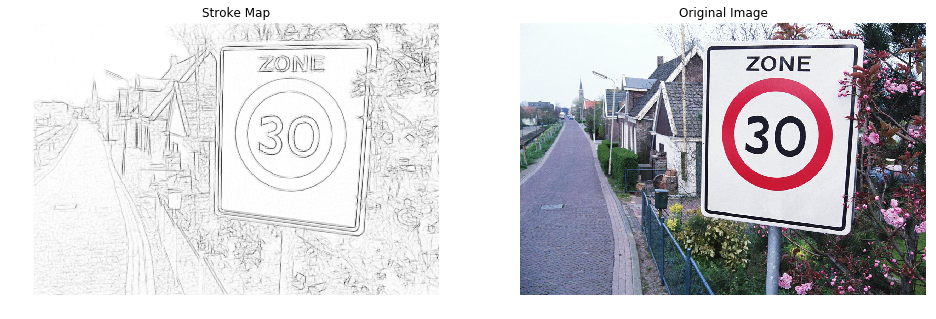

In [3]:
# Let's see an example Stroke Map:
ex_img = io.imread('./inputs/7--129.jpg')
ex_img_yuv = color.rgb2yuv(ex_img)
ex_img_y_ch = ex_img_yuv[:,:,0]
ex_img_stroke_map = gen_stroke_map(ex_img_y_ch, kernel_size=8, stroke_width=1,
                                   num_of_directions=8, smooth_kernel="gauss", gradient_method=1)
plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(1,2,1)
plt.imshow(ex_img_stroke_map, cmap='gray')
plt.axis('off')
plt.title('Stroke Map')
plt.subplot(1,2,2)
plt.imshow(ex_img)
plt.axis('off')
plt.title('Original Image')
plt.show()

### Tone Map Generation
We define 3 main tones: bright (b), mild (m), dark (d).

This method is called "Model-based Tone Transfer) - we use a parametric model to represent the target tone distribution:
$$ p(v) = \frac{1}{Z}\sum_{i=1}^{3}\omega_ip_i(v) $$ where v is the tone value, p(v) is the probability that a pixel in a pencil drawing is with value v and $\omega_i$ is the weight that corresponds to the number of pixels in each layer. Z is a normalization parameter to keep the probability in the safe region. We later define 3 groups of empirically tested $ \omega_i$'s.

* For the bright (b) layer, we use Laplacian distribution: $$ p_1(v) =
  \begin{cases}
    \frac{1}{\sigma_b}e^{-\frac{1 - v}{\sigma_b}}       & \quad \text{if } v \leq 1 \\
    0  & \quad \text{else}
  \end{cases}
$$ where $\sigma_b$ is the scale of the distribution (learned parameter, calculated later)

* For the mild (m) layer, we use uniform distribution: $$ p_2(v) =
  \begin{cases}
    \frac{1}{u_b - u_a}       & \quad \text{if } u_a \leq v \leq u_b \\
    0  & \quad \text{else}
  \end{cases}
$$ where $u_a$, $u_b$ are the ranges of the distribution (calculated later)

* For the dark (d) tone, we use Gaussian distribution: $$ p_3(v) = \frac{1}{\sqrt{2\pi\sigma_d}}e^{-\frac{(v-\mu_d)^2}{2\sigma_d^2}} $$ where $\sigma_d$ is the scale of the distribution (learned parameter, calculated later)

#### Parameter Learning based on MLE (Maximum Likelihood)
We define:
* m := mean of pixel values in each layer
* s:= STD of pixel values in each layer
* $x_i$ := pixel value
* N := number of pixels in the layer
Using MLE, we get the following results:
$$ \sigma_b = \frac{1}{N}\sum_{i=1}^{N}|x_i - 1| $$ $$ u_a = m_m - \sqrt{3}s_m , u_a = m_m + \sqrt{3}s_m $$ $$\mu_d = m_d, \sigma_d = s_d $$

The weights are divided into 3 groups:
$$ \omega_1:\omega_2:\omega_3 = 11:37:52 $$
$$ \omega_1:\omega_2:\omega_3 = 29:29:42 $$
$$ \omega_1:\omega_2:\omega_3 = 2:22:76 $$

The result image J is the tone adjusted input image, using histogram equaliztion.

For simplicity, we will use general parameters as in the paper.

In [4]:
# Generate Tone Map
# Make sure input image is in [0,1]
def gen_tone_map(img, w_group=0):
    # The first thing we need to do is to calculate the parameters and define weight groups
    w_mat = np.array([[11, 37, 52],
                     [29, 29, 42],
                     [2, 22, 76]])
    w = w_mat[w_group,:]
    # We can now define tone levels like:
    # dark: [0-85]
    # mild: [86-170]
    # bright: [171-255]
    # Assign each pixel a tone level, make 3 lists where each list holds the pixels (indices) of every tone.
    # Use these lists to calculate the parameters for each image.
    
    # For simplicity, we will use the parameters from the paper:
    # for the mild layer:
    u_b = 225
    u_a = 105
    # for the bright layer:
    sigma_b = 9
    # for the dark layer:
    mu_d = 90
    sigma_d = 11
    
    # Let's calculate the new histogram (p(v)):
    num_pixel_vals = 256
    p = np.zeros(num_pixel_vals)
    for v in range(num_pixel_vals):
        p1 = (1 / sigma_b) * np.exp(-(255 - v) / sigma_b)
        if (u_a <= v <= u_b):
            p2 = 1 / (u_b - u_a)
        else:
            p2 = 0
        p3 = (1 / np.sqrt(2 * np.pi * sigma_d)) * np.exp( (-np.square(v - mu_d)) / (2 * np.square(sigma_d)) )
        p[v] = w[0] * p1 + w[1] * p2 + w[2] * p3 * 0.01
    # normalize the histogram:
    p_normalized = p / np.sum(p)
    # calculate the CDF of the desired histogram:
    P = np.cumsum(p_normalized)
    # calculate the original histogram:
    h = exposure.histogram(img, nbins=256)
    # CDF of original:
    H = np.cumsum(h / np.sum(h))
    # histogram matching:
    lut = np.zeros_like(p)
    for v in range(num_pixel_vals):
        # find the closest value:
        dist = np.abs(P - H[v])
        argmin_dist = np.argmin(dist)
        lut[v] = argmin_dist
    lut_normalized = lut / num_pixel_vals
    J = lut_normalized[(255 * img).astype(np.int)]
    # smooth:
    J_smoothed = filters.gaussian(J, sigma=np.sqrt(2))
    return J_smoothed
    

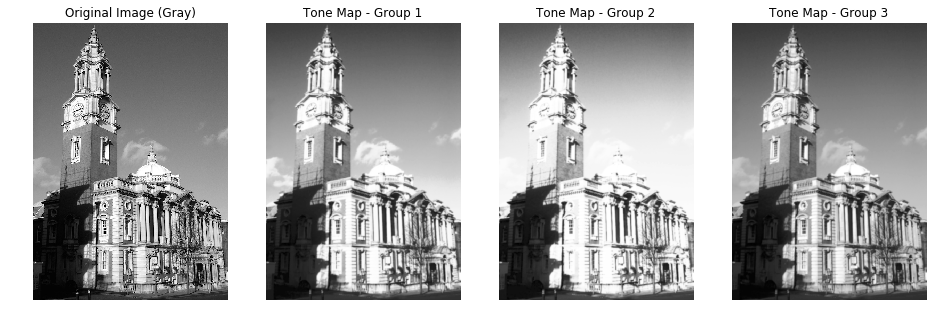

In [5]:
# Let's see an example Tone Map:
ex_img = io.imread('./inputs/2--31.jpg')
ex_img_yuv = color.rgb2yuv(ex_img)
ex_img_y_ch = ex_img_yuv[:,:,0]
ex_img_tone_map_0 = gen_tone_map(ex_img_y_ch, w_group=0)
ex_img_tone_map_1 = gen_tone_map(ex_img_y_ch, w_group=1)
ex_img_tone_map_2 = gen_tone_map(ex_img_y_ch, w_group=2)
plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(1,4,1)
plt.imshow(ex_img_y_ch, cmap='gray')
plt.axis('off')
plt.title('Original Image (Gray)')
plt.subplot(1,4,2)
plt.imshow(ex_img_tone_map_0, cmap='gray')
plt.axis('off')
plt.title('Tone Map - Group 1')
plt.subplot(1,4,3)
plt.imshow(ex_img_tone_map_1, cmap='gray')
plt.axis('off')
plt.title('Tone Map - Group 2')
plt.subplot(1,4,4)
plt.imshow(ex_img_tone_map_2, cmap='gray')
plt.axis('off')
plt.title('Tone Map - Group 3')

plt.show()

### Pencil Texture Rendering
Given H - real pencil textures, we wish to learn human-drawn tonal patterns. In real-life, those are generated by repeadtly drawing at the same place. We will use the following: (located in './pencils' directory)
<img src="./pencils/pencil0.jpg" height="300" width="300" />
<img src="./pencils/pencil1.jpg" height="300" width="300" />
<img src="./pencils/pencil3.jpg" height="300" width="300" />
<img src="./pencils/pencil4.jpg" height="300" width="300" />

In the process we are using multiplication of H's to find an approximation for J such that:
$$ H(x)^{\beta(x)} \approx J(x) $$ or in the log-domain:
$$ {\beta(x)}log(H(x)) \approx log(J(x)) $$
We wish to solve:
<img src="./images/h_beta.jpg" />
where $ \lambda = 0.2 $. This equation is solved using conjugate gradient.

The final pencil texture map T:
$$ T = H^{\beta^*} $$

In [6]:
# Generate Pencil Texture:
def gen_pencil_texture(img, H, J):
    # define the regularization parameter:
    lamda = 0.2
    height = img.shape[0]
    width = img.shape[1]
    # Adjust the input to correspond
#     H_res = transform.resize(H,(height, width))
    H_res = cv2.resize(H, (width, height), interpolation=cv2.INTER_CUBIC)
    H_res_reshaped = np.reshape(H_res, (height * width, 1))
    logH = np.log(H_res_reshaped)
    
#     J_res = transform.resize(J,(height, width))
    J_res = cv2.resize(J, (width, height), interpolation=cv2.INTER_CUBIC)
    J_res_reshaped = np.reshape(J_res, (height * width, 1))
    logJ = np.log(J_res_reshaped)
    
    # In order to use Conjugate Gradient method we need to prepare some sparse matrices:
    logH_sparse = sparse.spdiags(logH.ravel(), 0, height*width, height*width) # 0 - from main diagonal
    e = np.ones((height * width, 1))
    ee = np.concatenate((-e,e), axis=1)
    diags_x = [0, height*width]
    diags_y = [0, 1]
    dx = sparse.spdiags(ee.T, diags_x, height*width, height*width)
    dy = sparse.spdiags(ee.T, diags_y, height*width, height*width)
    
    # Compute matrix X and b: (to solve Ax = b)
    A = lamda * ((dx @ dx.T) + (dy @ dy.T)) + logH_sparse.T @ logH_sparse
    b = logH_sparse.T @ logJ
    
    # Conjugate Gradient
    beta = sparse.linalg.cg(A, b, tol=1e-6, maxiter=60)
    
    # Adjust the result
    beta_reshaped = np.reshape(beta[0], (height, width))
    
    # The final pencil texture map T
    T = np.power(H_res, beta_reshaped)
    
    return T
    

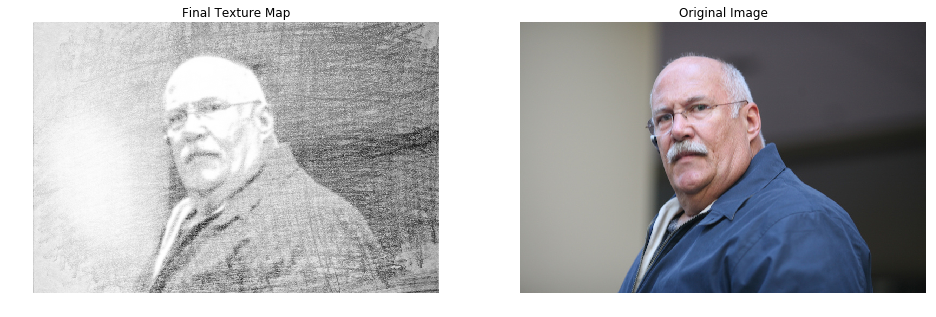

In [7]:
# Let's see an example Pencil Texture Map:
ex_img = io.imread('./inputs/3--17.jpg')
ex_img_yuv = color.rgb2yuv(ex_img)
ex_img_y_ch = ex_img_yuv[:,:,0]
pencil_tex = io.imread('./pencils/pencil0.jpg', as_gray=True)
ex_img_tone_map_0 = gen_tone_map(ex_img_y_ch, w_group=0)
ex_img_tex_map = gen_pencil_texture(ex_img_y_ch, pencil_tex, ex_img_tone_map_0)

plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(1,2,1)
plt.imshow(ex_img_tex_map, cmap='gray')
plt.axis('off')
plt.title('Final Texture Map')
plt.subplot(1,2,2)
plt.imshow(ex_img)
plt.axis('off')
plt.title('Original Image')
plt.show()

### Combine Everything
The final step is to combine all of the results from previous steps as follows:
$$ R = S \times T $$
where R is brightness channel in the YUV space, or the final omage in case the image is grayscale

In [12]:
# It's time to pack it all up (WOOHOOO!)
def gen_pencil_drawing(img, kernel_size, stroke_width=0, num_of_directions=8, smooth_kernel="gauss",
                       gradient_method=0, rgb=False, w_group=0, pencil_texture_path="", stroke_darkness=1, tone_darkness=1):
    if not rgb:
        # Grayscale image:
        im = img
    else:
        # RGB image:
        yuv_img = color.rgb2yuv(img)
        im = yuv_img[:,:,0]
    # Generate the Stroke Map:
    S = gen_stroke_map(im, kernel_size, stroke_width=stroke_width, num_of_directions=num_of_directions,
                       smooth_kernel=smooth_kernel, gradient_method=gradient_method)
    S = np.power(S, stroke_darkness)
    # Generate the Tone Map:
    J = gen_tone_map(im, w_group=w_group)
    
    # Read the pencil texture:
    if not pencil_texture_path:
        pencil_texture = io.imread('./pencils/pencil0.jpg', as_gray=True)
    else:
        pencil_texture = io.imread(pencil_texture_path, as_gray=True)
    # Generate the Pencil Texture Map:
    T = gen_pencil_texture(im, pencil_texture, J)
    T = np.power(T, tone_darkness)
    # The final Y channel:
    R = np.multiply(S, T)
    
    if not rgb:
        return R
    else:
        yuv_img[:,:,0] = R
        return exposure.rescale_intensity(color.yuv2rgb(yuv_img), in_range=(0, 1))

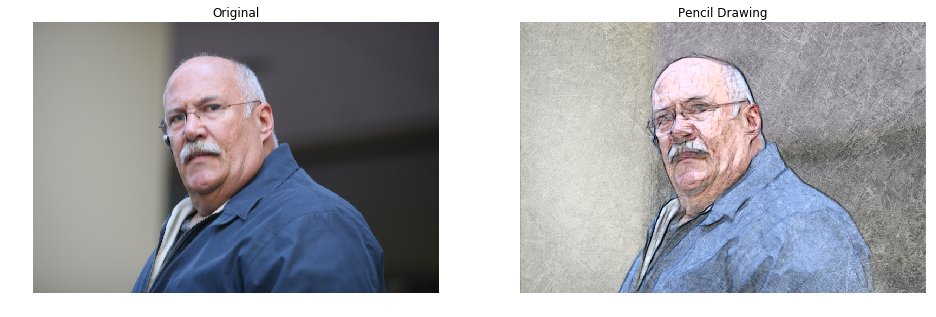

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


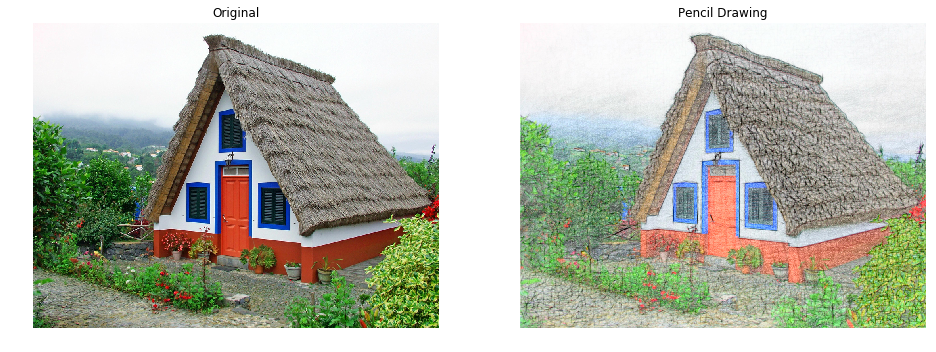

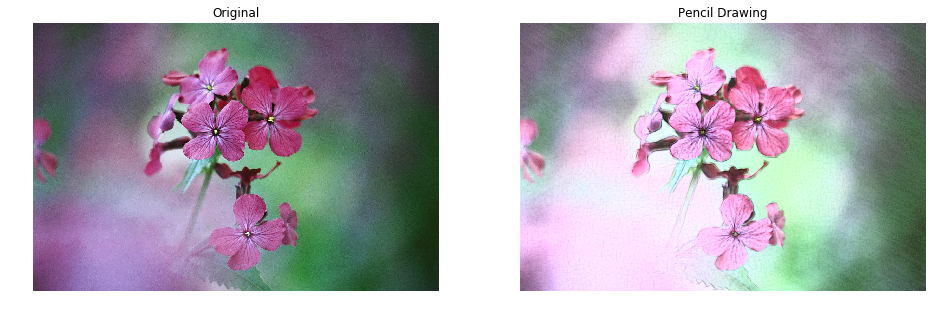

In [14]:
# Let's see some results
plt.subplot(1,2,1)
ex_img = io.imread('./inputs/3--17.jpg')
pencil_tex = './pencils/pencil1.jpg'
ex_im_pen = gen_pencil_drawing(ex_img, kernel_size=8, stroke_width=1, num_of_directions=8, smooth_kernel="gauss",
                       gradient_method=1, rgb=True, w_group=2, pencil_texture_path=pencil_tex,
                               stroke_darkness= 2,tone_darkness=1.5)
plt.imshow(ex_img)
plt.axis("off")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(ex_im_pen)
plt.axis("off")
plt.title("Pencil Drawing")
plt.show()

plt.subplot(1,2,1)
ex_img = io.imread('./inputs/2--83.jpg')
pencil_tex = './pencils/pencil0.jpg'
ex_im_pen = gen_pencil_drawing(ex_img, kernel_size=8, stroke_width=2, num_of_directions=8, smooth_kernel="median",
                       gradient_method=0, rgb=True, w_group=0, pencil_texture_path=pencil_tex,
                               stroke_darkness= 2,tone_darkness=1.5)
plt.imshow(ex_img)
plt.axis("off")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(ex_im_pen)
plt.axis("off")
plt.title("Pencil Drawing")
plt.show()

plt.subplot(1,2,1)
ex_img = io.imread('./inputs/17--8.jpg')
pencil_tex = './pencils/pencil3.jpg'
ex_im_pen = gen_pencil_drawing(ex_img, kernel_size=8, stroke_width=0, num_of_directions=8, smooth_kernel="gauss",
                       gradient_method=1, rgb=True, w_group=1, pencil_texture_path=pencil_tex,
                               stroke_darkness= 2,tone_darkness=1.5)
plt.imshow(ex_img)
plt.axis("off")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(ex_im_pen)
plt.axis("off")
plt.title("Pencil Drawing")
plt.show()